#### Notes: December 6

*  Make a mask for the non-zero indices - don't add noise to zero coefficients
* 0.1 sigma noise to everything, gaussian distribution 
* Do not add noise to the diagonal of the contemporaneous

#### Ways to draw general covmat
Try drawing it as a random vector in larger matrix - then checking that it is postitive definite

#### Notes: December 12
'Normal' simulation is still strange, variance is way too small given what we expect. 
Next step is look at the R notebook to check that we are in agreement with the previous work



In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import os
from scipy.stats import norm
%matplotlib inline

path='/Users/reneehlozek/Code/CIFAR_Network/GIMME/220429.FinalMatrices/'
import matplotlib as mpl
mpl.rc('image', cmap='cool')
number = 4
size=6
file = path+'%i.csv'%number
cols = 2*size
data = np.loadtxt(file, skiprows=1, usecols=range(0,cols), delimiter=',')
A = data[:,size:] #same day (contemporaneous) beta values
B = data[:,:size] #lagged beta values
# cov = np.random.randn(size,size)# +np.eye(size)
# cov/=np.diag(cov)
# cov*=0.05
cov = np.ones((size,size))


1.08714527970971
0.994844789461
1.02324048550316
1.3703398313147497
1.9517416126428397
1.22499408749556


Text(0.5, 1.0, 'Original Simulation')

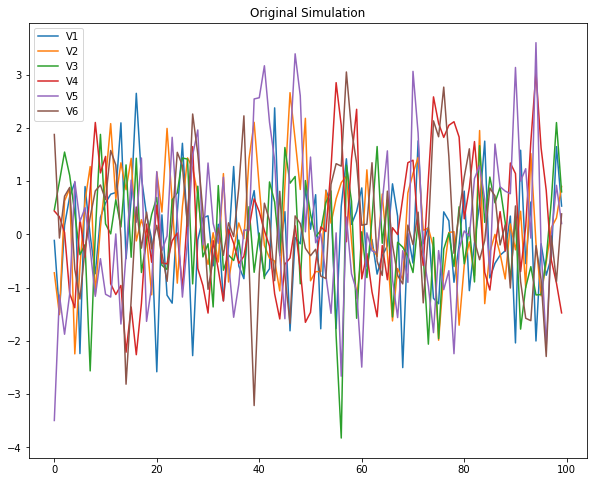

In [47]:
checkpath = '/Users/reneehlozek/Code/CIFAR_Network/GIMME_TS_CHECK/data/'
checkfile=checkpath+'ind_%i.csv'%number
checkdata=np.loadtxt(checkfile, skiprows=1, usecols=range(0,size), delimiter=',')
fig=plt.figure(1, figsize=(10,8))
for i in range(size):
    plt.plot(checkdata[:,i], label='V%i'%(i+1))
    print(np.var(checkdata[:,i]))
plt.legend(loc='best')
plt.title('Original Simulation')

0.39012335950488597
0.5595693926517689
0.5040953482267599
0.4386630764174372
0.5071802977471083
0.32025895162562135


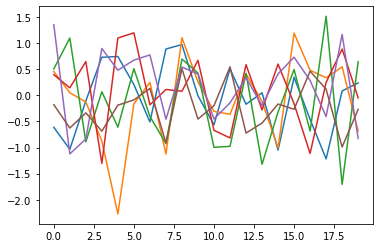

In [46]:
testamp = 0.5
mat = testamp*np.eye(size)

vector = np.random.multivariate_normal(np.zeros(size), mat,100)
for i in range(size):

    plt.plot(vector[0:20,i])
    print(np.var(vector[:,i]))

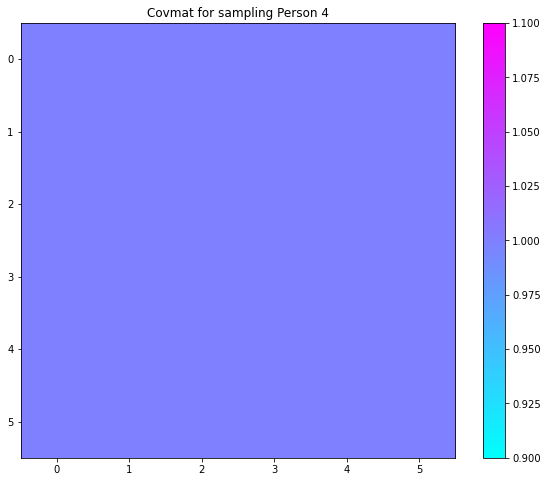

In [2]:
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
plt.imshow(cov)
plt.colorbar()
plt.title('Covmat for sampling Person %i'%number)
plt.savefig('covmat_%i.png'%number)

In [3]:
def make_mask(mat, contemp):
    size = np.shape(mat)[0]
    mask = np.ones((size,size))

    # Also only want to iterate over contemporaneous variables that are not set by themselves
    if contemp:
        np.fill_diagonal(mask,0)
     # Only want to iterate on entries that are non-zero
    
    inds = np.where(mat==0)
    mask[inds]=0
    
    return mask

def coeff_draw_from_cov(amplitude, mat,cov,mask):
    "draw a coefficient matrix from the mean matrix and the covariance"
    import numpy as np
    import matplotlib.pyplot as plt
    size=len(cov)
    sample_step = np.matmul(cov,np.dot(amplitude,np.random.randn(size,size))) 
    # make a draw of the covariance matrix
    stepmat = np.matmul(mat,(np.eye(size,size) + sample_step))
    noisy_mat = np.multiply(mask,stepmat)# mask out the relevant terms
    
#    noisy_mat = mat+np.matmul(np.dot(amplitude*np.random.rand(size,size), cov), mask)
    
    return noisy_mat


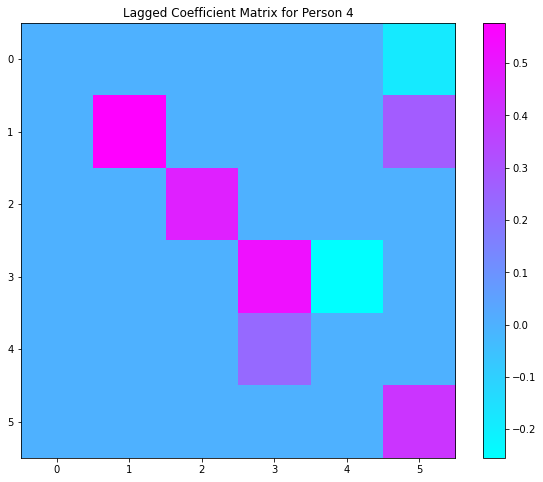

In [4]:
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
plt.imshow(B)
plt.colorbar()
plt.title('Lagged Coefficient Matrix for Person %i'%number)
plt.savefig('lagmat_%i.png'%number)

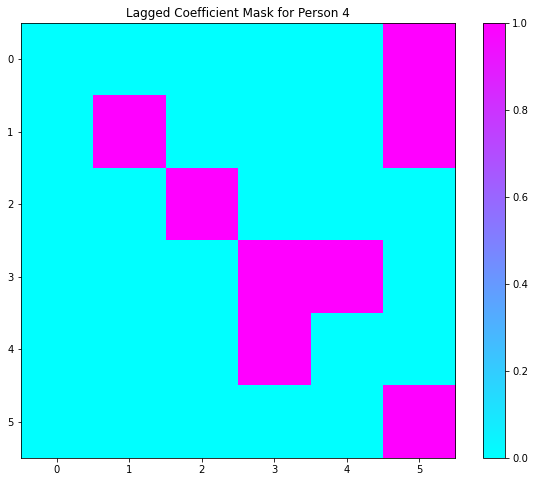

In [5]:
mask = make_mask(B, contemp=False)
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
plt.imshow(mask)
plt.title('Lagged Coefficient Mask for Person %i'%number)
plt.colorbar()
plt.savefig('lagmask_%i.png'%number)

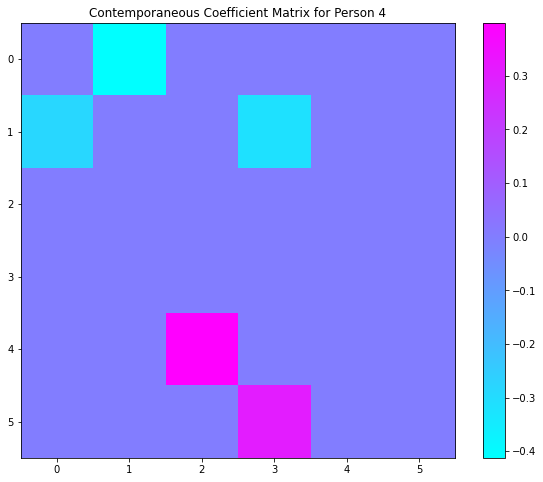

In [6]:
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
plt.imshow(A)
plt.colorbar()
plt.title('Contemporaneous Coefficient Matrix for Person %i'%number)
plt.savefig('contempmat_%i.png'%number)

In [7]:
# newcov = (cov+np.dot(0.01*np.random.rand(size,size), cov))
# plt.matshow(newcov)
# plt.colorbar()


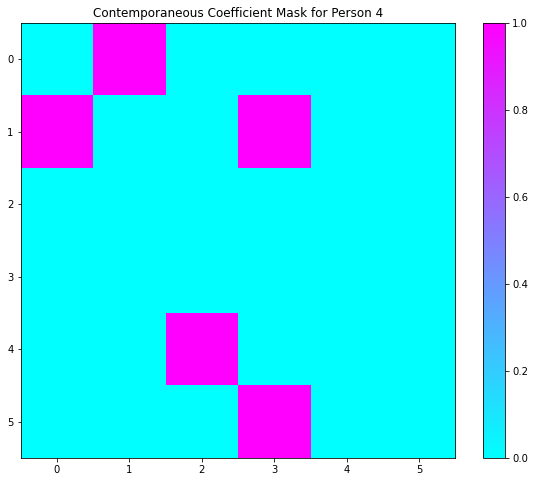

In [8]:
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
maskA = make_mask(A, contemp=False)
plt.imshow(maskA)
plt.title('Contemporaneous Coefficient Mask for Person %i'%number)
plt.colorbar()
plt.savefig('contempmask_%i.png'%number)

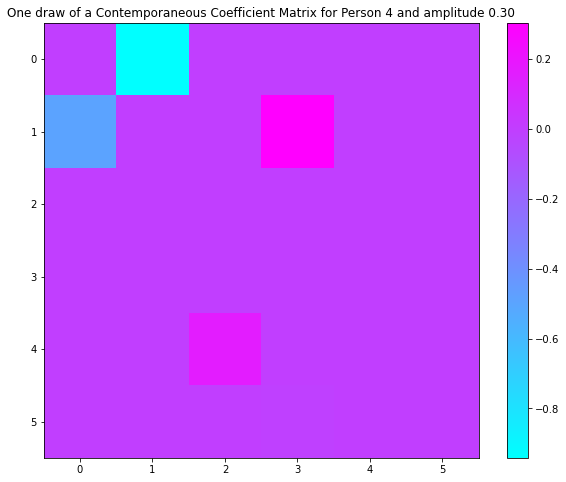

In [9]:
fig=plt.figure(10, figsize=(10,8))
fig.patch.set_facecolor('white')
amp=0.3
As = coeff_draw_from_cov(amp,A,cov,maskA)
plt.imshow(As)
plt.title('One draw of a Contemporaneous Coefficient Matrix for Person %i and amplitude %1.2f'%(number,amp))
plt.colorbar()
plt.savefig('noisy_%1.1fcontempmat_%i.png'%(number, amp))


In [32]:
def generate_timeseries(start,len,amplitude, contempmat, contempcov, lagmat, lagcov, measurecov):
    ''' Y = Ylag*lagmat + Y*contempmat
    so Y= (Ylag*lagmat)*(I-contempmat)^-1
    '''
    size=np.shape(start)[0]
    #print(size,len)
    samples = np.zeros((len,size))
    samples[0,:] = start
    lagmask = make_mask(contempmat, contemp=True)
    contempmask = make_mask(lagmat, contemp=False)

    for i in range(1,len):
        
        noisy_lagmat = coeff_draw_from_cov(amplitude, lagmat,lagcov, lagmask)
        #print('step = ', i)
        #print(noisy_lagmat)

        # plt.figure(1)
        # plt.imshow((noisy_lagmat-lagmat)/lagmat)
        # if i==1:
        #     plt.colorbar()
        # plt.title('lagmat')
        
        noisy_contempmat = coeff_draw_from_cov(amplitude, contempmat,contempcov, contempmask)
        #print(noisy_contempmat)
        # plt.figure(2)
        # plt.imshow((noisy_contempmat-contempmat)/contempmat)
        # if i==1:
        #     plt.colorbar()
        # plt.title('contempmat')
        
        #print(np.shape(np.matmul(samples[i-1,:], noisy_lagmat)), 'ylag*lagmat')
        #print(np.shape(np.matmul(np.matmul(samples[i-1,:], noisy_lagmat),np.linalg.inv(np.eye(size)-noisy_contempmat))))
        #print(np.matmul(samples[i-1,:], noisy_lagmat))
        samples[i,:] = np.matmul(np.matmul(samples[i-1,:], noisy_lagmat),np.linalg.inv(np.eye(size)-noisy_contempmat))+start
        samples[i,:]+=np.random.multivariate_normal(np.zeros(size),measurecov) # adding additional measurement noise

    #clipping all to be within 0-5

    # indices = np.where(samples[:,:]<-10)[0]
    # samples[indices] = -10
    # indices = np.where(samples[:,:]>10)[0]
    # samples[indices] = 10
    
    samples-=start
    return samples



0.0003300117873185371
1.754441105468133e-05
3.8395246712862346e-05
0.0009902251699437233
0.0
4.0648663195370536e-08
amp=0.01
----------------------
0.03885161881931239
0.0023463471773204968
0.003103074287053186
0.09343323309232254
0.0
0.0004238284654074621
amp=0.10
----------------------
2.847249626271296
4.442732889429133
0.06739344835073958
9.581857857287723
0.0
2.503393660804266
amp=0.50
----------------------


<Figure size 432x288 with 0 Axes>

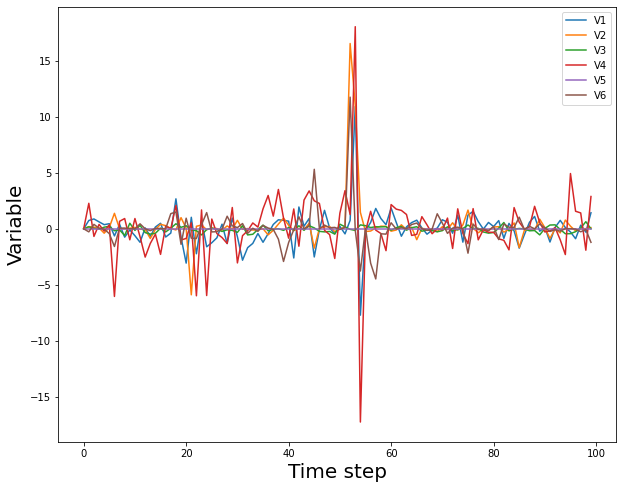

In [50]:
amps=[0.01, 0.1, 0.5]

for amp in amps:

    samples = generate_timeseries(np.array([1,1,1,1,1,1]),100, amp, A, cov, B, cov,0.0*cov)

    plt.clf()

    fig=plt.figure(3, figsize=(10,8))
    fig.patch.set_facecolor('white')
    for val in range(size):
        plt.plot(samples[:,val], label='V%i'%(val+1))
        print(np.var(samples[:,val]))
    plt.xlabel('Time step', fontsize=20)
    plt.ylabel('Variable', fontsize=20)
    plt.legend(loc='best')
    plt.savefig('samples_amplitude%1.1f.png'%amp)
    print('amp=%2.2f'%amp)
    print('----------------------')

<Figure size 432x288 with 0 Axes>

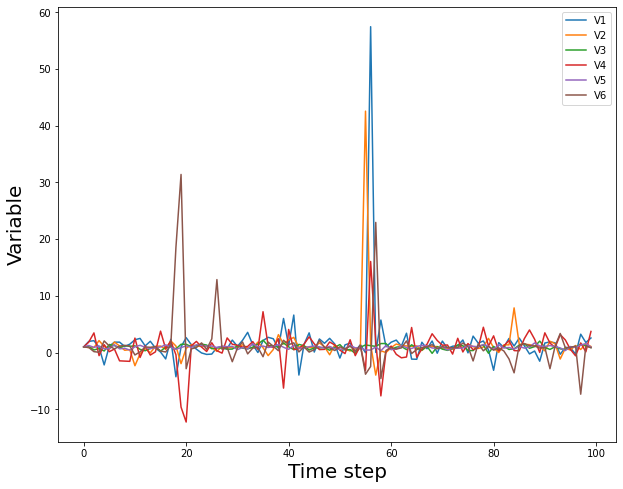

In [22]:
amp=0.5
samples = generate_timeseries(np.array([1,1,1,1,1,1]),100, amp, A, cov, B, cov,0.1*np.eye(size,size))

plt.clf()

fig=plt.figure(3, figsize=(10,8))
fig.patch.set_facecolor('white')
for val in range(size):
    plt.plot(samples[:,val], label='V%i'%(val+1))
plt.xlabel('Time step', fontsize=20)
plt.ylabel('Variable', fontsize=20)
plt.legend(loc='best')
plt.savefig('samples_amplitude%1.1f_withmeasurecov0.1.png'%amp)